In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import cftime

### 123 kgN fertilizer experiment

In [2]:
fert_amount = "123"
case_clarion = "MESOCOSM_Clarion_" + fert_amount + "kgN"
case_webster = "MESOCOSM_Webster_" + fert_amount + "kgN"
path_clarion = "/glade/scratch/jinmuluo/archive/" + case_clarion + "/lnd/hist/" 
path_webster = "/glade/scratch/jinmuluo/archive/" + case_webster + "/lnd/hist/" 
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 1)
NO_LEAP = True
delta_days = (end_date - start_date).days

NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 
          'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
          'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", 
         "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]
Others = ["FAN_TOTN", "NITRATE_TOTN",'SMINN', 'SMINN_vr', 'SMIN_NH4_vr', 'SMIN_NO3_vr', 'QOVER', 'H2OSOI', 'TSOI_10CM',
         'SMINN_TO_PLANT_FUN_NO3', 'SMINN_TO_PLANT_FUN_NH4', 'SMINN_TO_PLANT_FUN', 'F_NIT', 'F_DENIT', 'GROSS_NMIN', 'ACTUAL_IMMOB_NH4', 'ACTUAL_IMMOB_NO3',
         'LEAFN', 'LIVESTEMN', 'FROOTN', 'LIVECROOTN', 'GRAINN', 'CROPPROD1N']

CLM_Clarion = []
CLM_Webster = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate + "-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate + "-00000.nc")

In [3]:
def preprocess(ds, fields= NInput + GAS + Others + RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)
dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)

x = np.zeros(len(dsCLM_Clarion['levsoi']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levsoi'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levsoi'][i].values - dsCLM_Clarion['levsoi'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth=(dsCLM_Clarion['levsoi'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth=(dsCLM_Webster['levsoi'].coords, x))

x = np.zeros(len(dsCLM_Clarion['levdcmp']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levdcmp'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levdcmp'][i].values - dsCLM_Clarion['levdcmp'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth2=(dsCLM_Clarion['levdcmp'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth2=(dsCLM_Webster['levdcmp'].coords, x))

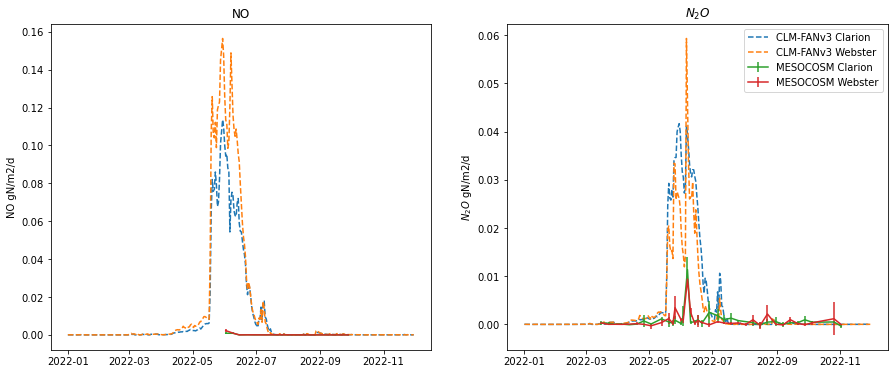

In [4]:
# Read the measurements
p2 = "/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'mesocosm_ghg_flux_data_2022.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

mean_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
std_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
mean_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
std_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
mean_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean()
std_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').std()
mean_dsN2O_web = dsN2O.loc[('Webster', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean()
std_dsN2O_web = dsN2O.loc[('Webster', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').std()
no_time = mean_dsNO_cla.index.values
n2o_time = mean_dsN2O_cla.index.values


# Read the model simulations
NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Webster.time]

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Webster.time]

# Plot the graph
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(NO_Clarion.time, NO_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion')
ax[0].plot(NO_Webster.time, NO_Webster.values, linestyle='--', label='CLM-FANv3 Webster')
ax[0].errorbar(no_time, mean_dsNO_cla.values, yerr=std_dsNO_cla.values, label='MESOCOSM Clarion')
ax[0].errorbar(no_time, mean_dsNO_web.values, yerr=std_dsNO_web.values, label='MESOCOSM Webster')
ax[0].set_title("NO")
ax[0].set_ylabel("NO gN/m2/d")

ax[1].plot(N2O_Clarion.time, N2O_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion')
ax[1].plot(N2O_Webster.time, N2O_Webster.values, linestyle='--', label='CLM-FANv3 Webster')
ax[1].errorbar(n2o_time, mean_dsN2O_cla.values, yerr=std_dsN2O_cla.values, label='MESOCOSM Clarion')
ax[1].errorbar(n2o_time, mean_dsN2O_web.values, yerr=std_dsN2O_web.values, label='MESOCOSM Webster')
ax[1].set_title("$N_2O$")
ax[1].set_ylabel("$N_2O$ gN/m2/d")
ax[1].legend()

fig.savefig("graphs/Ngas_123kgN.jpg", dpi=300)
plt.show()

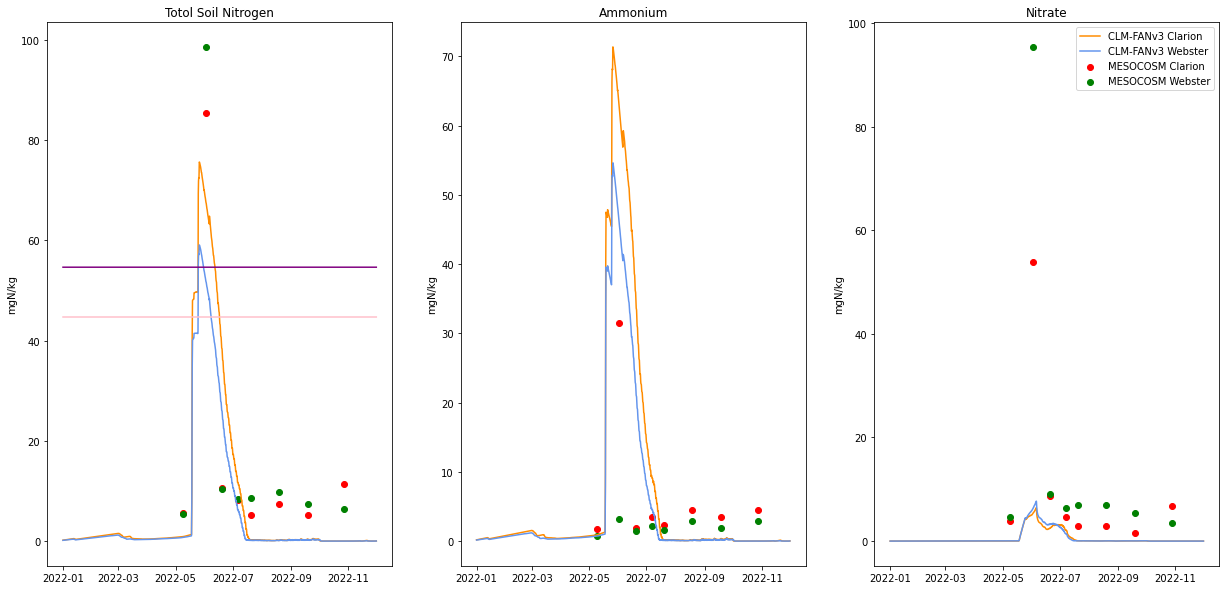

In [5]:
# Read the measurement
fert_date = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
dsMESOCOSM = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mescocosm_extracted_soil_nitrogen_2022.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

sminn_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_sminn'].groupby(level='date').mean()
sminn_cla_std = dsMESOCOSM.loc[('Clarion', 123), 'soil_sminn'].groupby(level='date').std()
sminn_web = dsMESOCOSM.loc[('Webster', 123), 'soil_sminn'].groupby(level='date').mean()
sminn_web_std = dsMESOCOSM.loc[('Webster', 123), 'soil_sminn'].groupby(level='date').std()
nh4_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_cla_std = dsMESOCOSM.loc[('Clarion', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
nh4_web = dsMESOCOSM.loc[('Webster', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_web_std = dsMESOCOSM.loc[('Webster', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
no3_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_cla_std = dsMESOCOSM.loc[('Clarion', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
no3_web = dsMESOCOSM.loc[('Webster', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_web_std = dsMESOCOSM.loc[('Webster', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
plot_time = no3_web.index.values

# Read the CLM simulation results
sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
## gN/m3 to mgN/kg at the top 9 cm soil, soil bulk density from Steven Hall, CLM uses soil density 2650
sminn_Clarion = sminn_Clarion*1000/1125
sminn_Webster = sminn_Webster*1000/1375
sminn_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Clarion.time]
sminn_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Webster.time]
## gN/m2 to mgN/kg, fertilization depth is around top 20cm
fert_conc_cla = 12.3*1000/0.2/1125
fert_conc_web = 12.3*1000/0.2/1375

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Clarion = nh4_Clarion*1000/1125
nh4_Webster = nh4_Webster*1000/1375
nh4_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Clarion.time]
nh4_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Webster.time]

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/1125
no3_Webster = no3_Webster*1000/1375
no3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Clarion.time]
no3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Webster.time]

# graph
fig, ax = plt.subplots(1, 3, figsize=(21, 10))
ax[0].plot(sminn_Clarion.time, sminn_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[0].plot(sminn_Webster.time, sminn_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_cla, color='purple')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_web, color='pink')
ax[0].scatter(plot_time, sminn_cla.values, label='MESOCOSM Clarion', color='red')
ax[0].scatter(plot_time, sminn_web.values, label='MESOCOSM Webster', color='green')
ax[0].set_title("Totol Soil Nitrogen")
ax[0].set_ylabel("mgN/kg")

ax[1].plot(sminn_Clarion.time, nh4_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[1].plot(sminn_Webster.time, nh4_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].scatter(plot_time, nh4_cla.values, label='MESOCOSM Clarion', color='red')
ax[1].scatter(plot_time, nh4_web.values, label='MESOCOSM Webster', color='green')
ax[1].set_title("Ammonium")
ax[1].set_ylabel("mgN/kg")

ax[2].plot(sminn_Clarion.time, no3_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[2].plot(sminn_Webster.time, no3_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].scatter(plot_time, no3_cla.values, label='MESOCOSM Clarion', color='red')
ax[2].scatter(plot_time, no3_web.values, label='MESOCOSM Webster', color='green')
ax[2].set_title("Nitrate")
ax[2].set_ylabel("mgN/kg")

plt.legend(loc="upper right")
fig.savefig("graphs/Nconc_123kgN.jpg", dpi=300)
plt.show()

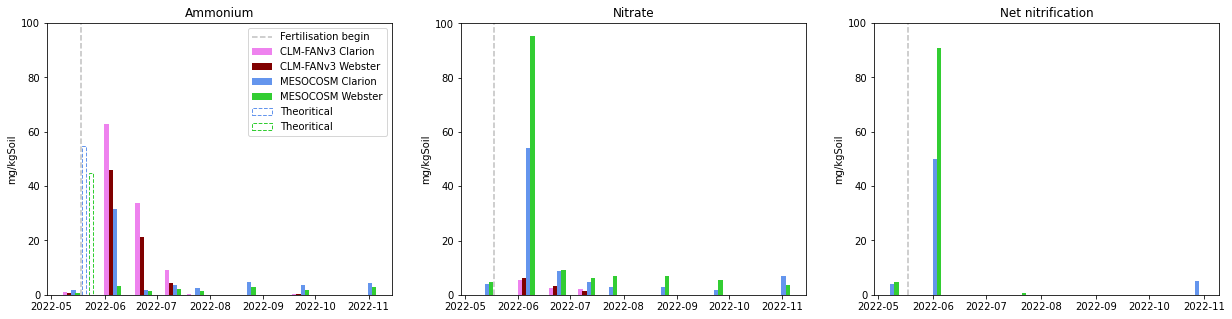

In [6]:
#
t_term = []
for t in plot_time:
    term = pd.to_datetime(t)
    x = cftime.DatetimeNoLeap(term.year, term.month, term.day)
    t_term.append(cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian'))
    
nh4_cla_bar = np.squeeze(nh4_Clarion.sel(time=t_term, method='nearest').values)
nh4_web_bar = np.squeeze(nh4_Webster.sel(time=t_term, method='nearest').values)
no3_cla_bar = np.squeeze(no3_Clarion.sel(time=t_term, method='nearest').values)
no3_web_bar = np.squeeze(no3_Webster.sel(time=t_term, method='nearest').values)
deni_cla = np.zeros(len(no3_cla.values))
deni_web = np.zeros(len(no3_web.values))

for i in range(len(no3_web.values)):
    if i == 0:
        deni_cla[i] = no3_cla.values[i]
        deni_web[i] = no3_web.values[i]
    else:
        deni_cla[i] = no3_cla.values[i] - no3_cla.values[i-1]
        deni_web[i] = no3_web.values[i] - no3_web.values[i-1]
        if deni_cla[i] < 0:
            deni_cla[i] = 0
        if deni_web[i] < 0:
            deni_web[i]=0

    
# Graph
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
drift = (plot_time[1] - plot_time[0])/10

ax[0].bar(plot_time, nh4_cla_bar, width=2.5, color='violet', label='CLM-FANv3 Clarion')
ax[0].bar(plot_time + drift, nh4_web_bar, width=2.5, color='maroon', label='CLM-FANv3 Webster')
ax[0].bar(plot_time + 2*drift, nh4_cla.values, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
#ax[0].errorbar(plot_time + 2*drift, nh4_cla.values, yerr=nh4_cla_std.values, fmt='o')
ax[0].bar(plot_time + 3*drift, nh4_web.values, width=2.5, color='limegreen', label='MESOCOSM Webster')
#ax[0].errorbar(plot_time + 3*drift, nh4_web_std.values, fmt='o')
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[0].bar(fert_date+2, fert_conc_cla, width=2.5, linestyle="--",  color='white', edgecolor='cornflowerblue', label='Theoritical')
ax[0].bar(fert_date+6, fert_conc_web, width=2.5, linestyle="--",  color='white', edgecolor='limegreen', label='Theoritical')
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('mg/kgSoil')
ax[0].set_title('Ammonium')
ax[0].legend()

ax[1].bar(plot_time, no3_cla_bar, width=2.5, color='violet', label='CLM-FANv3 Clarion')
ax[1].bar(plot_time + drift, no3_web_bar, width=2.5, color='maroon', label='CLM-FANv3 Webster')
ax[1].bar(plot_time + 2*drift, no3_cla.values, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
ax[1].bar(plot_time + 3*drift, no3_web.values, width=2.5, color='limegreen', label='MESOCOSM Webster')
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[1].set_ylabel('mg/kgSoil')
ax[1].set_title('Nitrate')

ax[2].bar(plot_time, deni_cla, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
ax[2].bar(plot_time + drift, deni_web, width=2.5, color='limegreen', label='MESOCOSM Webster')
ax[2].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[2].set_ylabel('mg/kgSoil')
ax[2].set_ylim(0, 100)
ax[2].set_title('Net nitrification')
fig.savefig("graphs/Nconc_bar_123kgN.jpg", dpi=300)
plt.show()

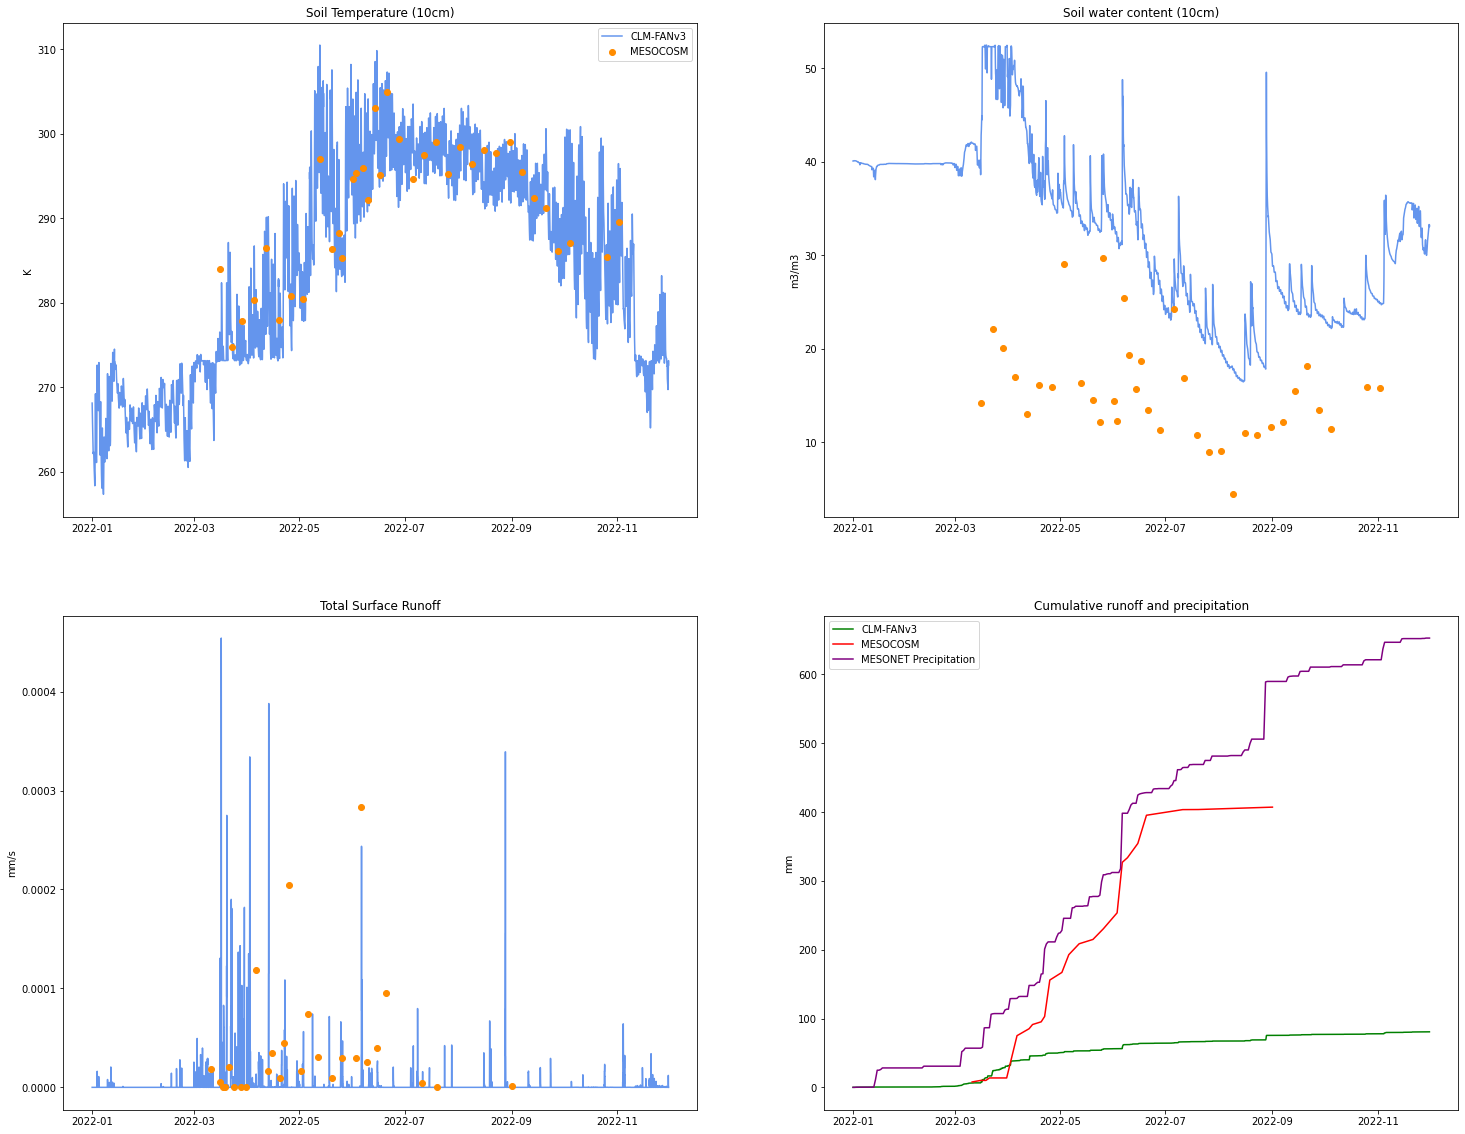

0.4620643718147093


In [7]:
# Read the measurements
dsSoil = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mesocosm_ghg_flux_data_2022.csv")
dsSoil['date'] = pd.to_datetime(dsSoil['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsSoil['air_temperature_K'] = dsSoil['air_temperature_C'] + 273.15
dsSoil.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsSoil = dsSoil.sort_index()

dsWater = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mesocosm_drainage_water_quantity_N_2023.csv")
dsWater['date'] = pd.to_datetime(dsWater['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
## Sampling period starts from the last sampling. 
dsWater['instantaneous_drainage_mm_s'] = dsWater['instantaneous_drainage_cm']*10/dsWater['st_days']/24/3600
dsWater['cumulative_drainage_mm'] = dsWater['cumulative_drainage_cm']*10
dsWater.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsWater = dsWater.sort_index()

air_tem = dsSoil.loc[('Clarion', 123), 'air_temperature_K'].groupby('date').mean()
h2o_meso = dsSoil.loc[('Clarion', 123), 'soil_moisture_volume_percent'].groupby('date').mean()
runoff_meso = dsWater.loc[('Clarion', 123), 'instantaneous_drainage_mm_s'].groupby('date').mean()
runoff_meso_cum = dsWater.loc[('Clarion', 123), 'cumulative_drainage_mm'].groupby('date').mean()

# CLM simulations
tem_sim = dsCLM_Clarion['TSOI_10CM']
tem_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in tem_sim.time]
h2o_sim = dsCLM_Clarion['H2OSOI'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')*100
h2o_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim.time]
runoff_sim = dsCLM_Clarion['QOVER']
runoff_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim.time]
## Hourly resolution, from mm/s to mm
runoff_sim_cum = (dsCLM_Clarion['QOVER']*3600).cumsum()
Prec = xr.open_mfdataset("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/datmdata/clmforc.BOOI4.Prec.isu_point.2022-*.nc")
Prec = Prec.sel(time=slice(cftime.DatetimeNoLeap(start_date.year, start_date.month, start_date.day), cftime.DatetimeNoLeap(end_date.year, end_date.month, end_date.day)))
## resample three hours to daily, and transform the unit form mm/sec to mm
Prec = Prec.resample(time='D').mean()*24*3600
Prec['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Prec.time]


# Graph
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
ax[0, 0].plot(tem_sim.time, tem_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0, 0].scatter(air_tem.index.values, air_tem, label='MESOCOSM', color='darkorange', zorder=2)
ax[0, 0].set_title("Soil Temperature (10cm)")
ax[0, 0].set_ylabel("K")
ax[0, 0].legend()

ax[0, 1].plot(h2o_sim.time, h2o_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0, 1].scatter(h2o_meso.index.values, h2o_meso.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[0, 1].set_title("Soil water content (10cm)")
ax[0, 1].set_ylabel("m3/m3")

ax[1, 0].plot(runoff_sim.time, runoff_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1, 0].scatter(runoff_meso.index.values, runoff_meso.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1, 0].set_title("Total Surface Runoff")
ax[1, 0].set_ylabel("mm/s")

ax[1, 1].plot(runoff_sim.time, runoff_sim_cum.values,label='CLM-FANv3', color='green')
ax[1, 1].plot(runoff_meso_cum.index.values, runoff_meso_cum.values, label='MESOCOSM', color='red')
ax[1, 1].plot(Prec.time, np.squeeze(Prec['PRECTmms'].cumsum().values), label='MESONET Precipitation', color='purple')
ax[1, 1].legend(loc='upper left')
ax[1, 1].set_title('Cumulative runoff and precipitation')
ax[1, 1].set_ylabel('mm')

fig.savefig("graphs/Env.jpg", dpi=300)
plt.show()

# Calculation
meso_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_meso.index]
h2o_sim_meso = h2o_sim.sel(time=meso_time)
print(((h2o_sim_meso.values - h2o_meso.values)/h2o_sim_meso.values).mean())

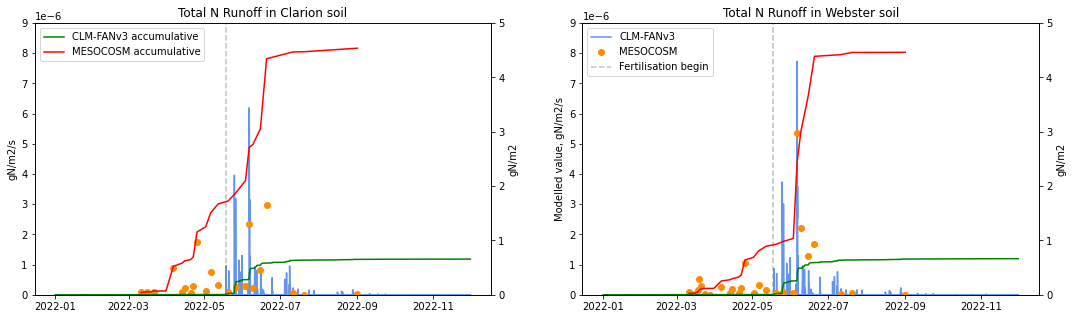

In [8]:
# Read the measuremnts
dsWater['instantaneous_drainage_nitrate_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_ammonium_gN_m2_s'] = dsWater['instantaneous_drainage_ammonium_N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_nitrogen_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_gN_m2_s'] + dsWater['instantaneous_drainage_ammonium_gN_m2_s']
dsWater['cumulative_nitrogen_gN_m2'] = dsWater['cumulative_ammonium_N_yield_kg_ha']/10 + dsWater['cumulative_nitrate_N_yield_kg_ha']/10

nrunoff_cla = dsWater.loc[('Clarion', 123), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
nrunoff_web = dsWater.loc[('Webster', 123), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
nrunoff_cum_cla = dsWater.loc[('Clarion', 123), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
nrunoff_cum_web = dsWater.loc[('Webster', 123), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
plottime = nrunoff_cla.index.values

# CLM simulations
Total_N_runoff_cla = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
Total_N_runoff_cla['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_runoff_cla.time]
Total_N_runoff_web = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']
Total_N_runoff_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_runoff_web.time]
## hourly resolution!!
Total_N_cum_runoff_cla = (Total_N_runoff_cla * 3600).cumsum()   
Total_N_cum_runoff_web = (Total_N_runoff_web * 3600).cumsum()

# Graph
fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax0 = ax[0].twinx()
ax[0].plot(Total_N_runoff_cla.time, Total_N_runoff_cla.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(plottime, nrunoff_cla.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Fertilisation begin')
ax[0].set_ylim(0, 9e-6)
ax[0].set_ylabel('gN/m2/s')
ax[0].set_title('Total N Runoff in Clarion soil')
ax0.plot(Total_N_cum_runoff_cla.time, Total_N_cum_runoff_cla.values, label='CLM-FANv3 accumulative', color='green')
ax0.plot(nrunoff_cum_cla.index.values, nrunoff_cum_cla.values, label='MESOCOSM accumulative', color='red')
ax0.set_ylabel('gN/m2')
ax0.set_ylim(0, 5)
ax0.legend(loc='upper left')

ax1 = ax[1].twinx()
ax[1].plot(Total_N_runoff_web.time, Total_N_runoff_web.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].scatter(plottime, nrunoff_web.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Fertilisation begin')
ax[1].set_ylim(0, 9e-6)
ax[1].set_ylabel('Modelled value, gN/m2/s')
ax[1].set_title('Total N Runoff in Webster soil')
ax[1].legend(loc='upper left')
ax1.plot(Total_N_cum_runoff_web.time, Total_N_cum_runoff_web.values, label='CLM-FANv3 cumulative', color='green')
ax1.plot(nrunoff_cum_web.index.values, nrunoff_cum_web.values, label='MESOCOSM accumulative', color='red')
ax1.set_ylabel('gN/m2')
ax1.set_ylim(0, 5)

fig.savefig("graphs/Runoff_123kg.jpg", dpi=300)
plt.show()

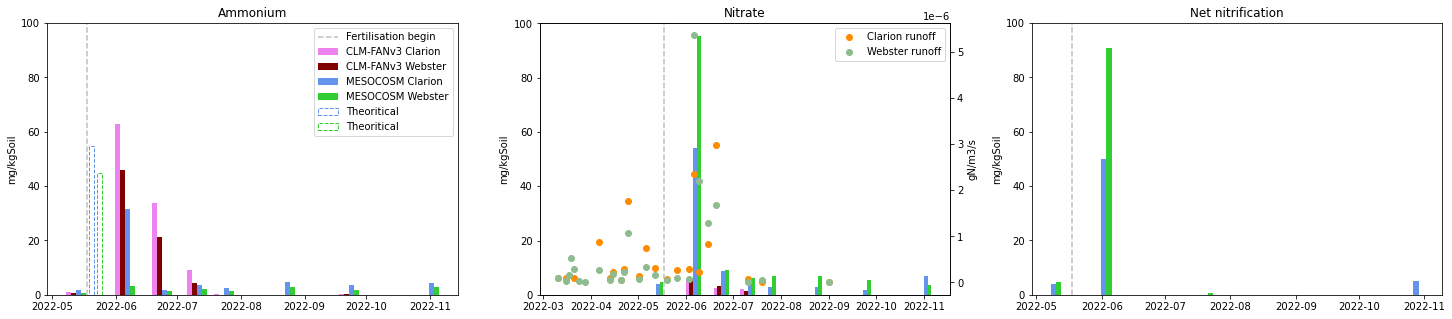

In [9]:
#
t_term = []
for t in plot_time:
    term = pd.to_datetime(t)
    x = cftime.DatetimeNoLeap(term.year, term.month, term.day)
    t_term.append(cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian'))
    
nh4_cla_bar = np.squeeze(nh4_Clarion.sel(time=t_term, method='nearest').values)
nh4_web_bar = np.squeeze(nh4_Webster.sel(time=t_term, method='nearest').values)
no3_cla_bar = np.squeeze(no3_Clarion.sel(time=t_term, method='nearest').values)
no3_web_bar = np.squeeze(no3_Webster.sel(time=t_term, method='nearest').values)
deni_cla = np.zeros(len(no3_cla.values))
deni_web = np.zeros(len(no3_web.values))

for i in range(len(no3_web.values)):
    if i == 0:
        deni_cla[i] = no3_cla.values[i]
        deni_web[i] = no3_web.values[i]
    else:
        deni_cla[i] = no3_cla.values[i] - no3_cla.values[i-1]
        deni_web[i] = no3_web.values[i] - no3_web.values[i-1]
        if deni_cla[i] < 0:
            deni_cla[i] = 0
        if deni_web[i] < 0:
            deni_web[i]=0

    
# Graph
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
drift = (plot_time[1] - plot_time[0])/10

ax[0].bar(plot_time, nh4_cla_bar, width=2.5, color='violet', label='CLM-FANv3 Clarion')
ax[0].bar(plot_time + drift, nh4_web_bar, width=2.5, color='maroon', label='CLM-FANv3 Webster')
ax[0].bar(plot_time + 2*drift, nh4_cla.values, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
#ax[0].errorbar(plot_time + 2*drift, nh4_cla.values, yerr=nh4_cla_std.values, fmt='o')
ax[0].bar(plot_time + 3*drift, nh4_web.values, width=2.5, color='limegreen', label='MESOCOSM Webster')
#ax[0].errorbar(plot_time + 3*drift, nh4_web_std.values, fmt='o')
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[0].bar(fert_date+2, fert_conc_cla, width=2.5, linestyle="--",  color='white', edgecolor='cornflowerblue', label='Theoritical')
ax[0].bar(fert_date+6, fert_conc_web, width=2.5, linestyle="--",  color='white', edgecolor='limegreen', label='Theoritical')
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('mg/kgSoil')
ax[0].set_title('Ammonium')
ax[0].legend()

ax1 = ax[1].twinx()
ax[1].bar(plot_time, no3_cla_bar, width=2.5, color='violet', label='CLM-FANv3 Clarion')
ax[1].bar(plot_time + drift, no3_web_bar, width=2.5, color='maroon', label='CLM-FANv3 Webster')
ax[1].bar(plot_time + 2*drift, no3_cla.values, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
ax[1].bar(plot_time + 3*drift, no3_web.values, width=2.5, color='limegreen', label='MESOCOSM Webster')
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax1.scatter(plottime, nrunoff_cla.values, label='Clarion runoff', color='darkorange', zorder=2)
ax1.scatter(plottime, nrunoff_web.values, label='Webster runoff', color='darkseagreen', zorder=2)
ax1.set_ylabel('gN/m3/s')
ax1.legend()
ax[1].set_ylabel('mg/kgSoil')
ax[1].set_title('Nitrate')

ax[2].bar(plot_time, deni_cla, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
ax[2].bar(plot_time + drift, deni_web, width=2.5, color='limegreen', label='MESOCOSM Webster')
ax[2].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[2].set_ylabel('mg/kgSoil')
ax[2].set_ylim(0, 100)
ax[2].set_title('Net nitrification')
fig.savefig("graphs/Nconc_bar_123kgN.jpg", dpi=300)
plt.show()

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/glade/scratch/jinmuluo/ipykernel_17891/1769936889.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time2 = dsCLM_Clarion.indexes['time'].to_datetimeindex()


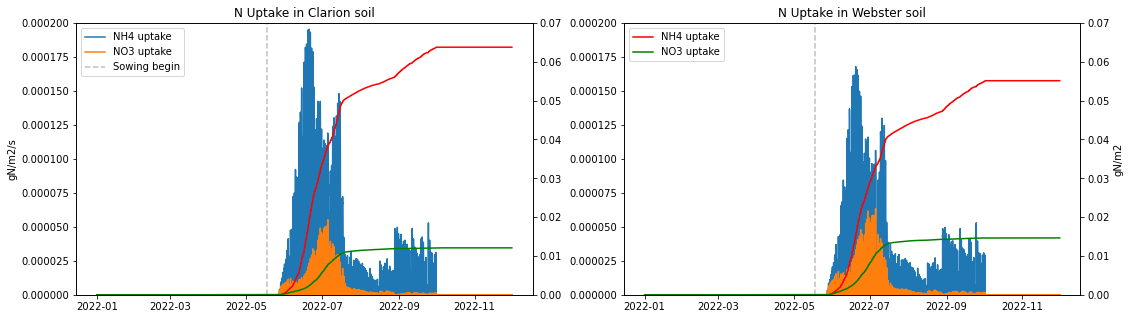

In [10]:
# CLM simulations
nh4_plant_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp')
no3_plant_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp')
nh4_plant_cum_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum()
no3_plant_cum_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum()

nh4_plant_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp')
no3_plant_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp')
nh4_plant_cum_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum()
no3_plant_cum_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum()

plot_time2 = dsCLM_Clarion.indexes['time'].to_datetimeindex()

# Graph
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax0 = ax[0].twinx()
ax1 = ax[1].twinx()

ax[0].plot(plot_time2, nh4_plant_cla.values, label='NH4 uptake')
ax[0].plot(plot_time2, no3_plant_cla.values, label='NO3 uptake')
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Sowing begin')
ax[0].set_ylabel('gN/m2/s')
ax[0].set_ylim(0, 0.000200)
ax[0].legend(loc='upper left')
ax[0].set_title('N Uptake in Clarion soil')
ax0.plot(plot_time2, nh4_plant_cum_cla.values, label='NH4 uptake', color='red')
ax0.plot(plot_time2, no3_plant_cum_cla.values, label='NO3 uptake', color='green')
ax0.set_ylim(0, 0.07)
ax0.set_ylabel('')

ax[1].plot(plot_time2, nh4_plant_web.values, label='NH4 uptake')
ax[1].plot(plot_time2, no3_plant_web.values, label='NO3 uptake')
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Sowing begin')
ax[1].set_title('N Uptake in Webster soil')
ax[1].set_ylim(0, 0.000200)
ax1.plot(plot_time2, nh4_plant_cum_web.values, label='NH4 uptake', color='red')
ax1.plot(plot_time2, no3_plant_cum_web.values, label='NO3 uptake', color='green')
ax1.set_ylim(0, 0.07)
ax1.set_ylabel('gN/m2')
ax1.legend(loc='upper left')

fig.savefig("graphs/Uptake_123kg.jpg", dpi=300)
plt.show()

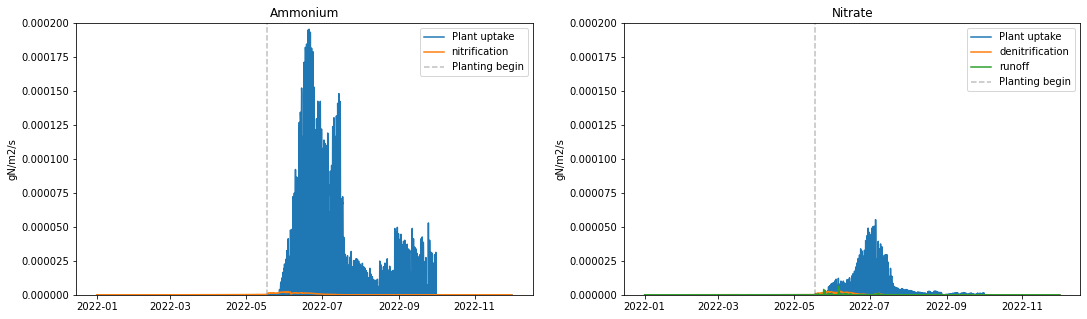

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].plot(plot_time2, nh4_plant_cla.values, label='Plant uptake')
ax[0].plot(plot_time2, dsCLM_Clarion['F_NIT'].values, label='nitrification')
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[0].set_ylabel('gN/m2/s')
ax[0].set_ylim(0, 0.0002)
ax[0].legend()
ax[0].set_title('Ammonium')

ax[1].plot(plot_time2, no3_plant_cla.values, label='Plant uptake')
ax[1].plot(plot_time2, dsCLM_Clarion['F_DENIT'].values, label='denitrification')
ax[1].plot(plot_time2, Total_N_runoff_cla.values, label='runoff')
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[1].set_ylabel('gN/m2/s')
ax[1].set_ylim(0, 0.0002)
ax[1].set_title('Nitrate')

plt.legend()
fig.savefig("graphs/N_flows_123kg.jpg", dpi=300)
plt.show()

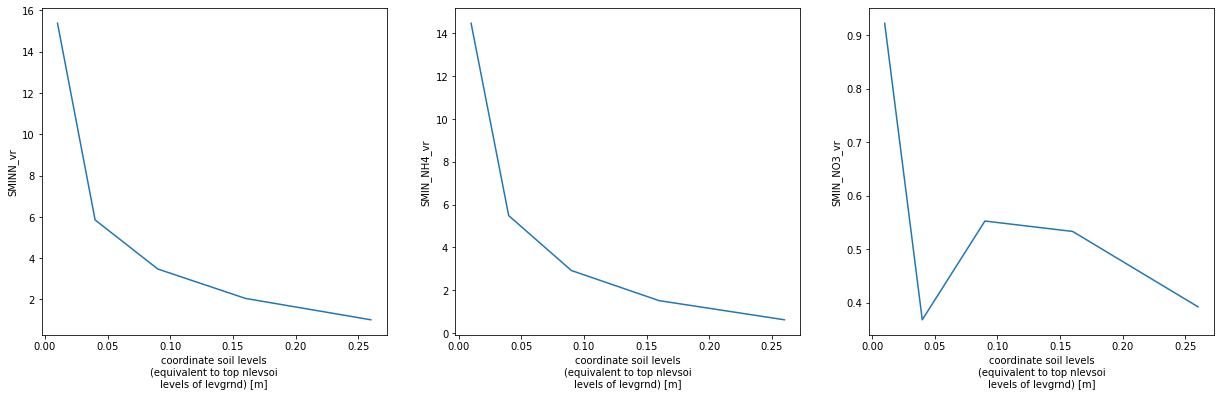

1.0356045620683902 1.2318061386974257 0.8407204100829462


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(21, 6))
dsCLM_Clarion['SMINN_vr'].mean(dim='time').sel(levsoi=[0.01, 0.04, 0.09, 0.16, 0.26]).plot(ax=ax[0])
dsCLM_Clarion['SMIN_NH4_vr'].mean(dim='time').sel(levsoi=[0.01, 0.04, 0.09, 0.16, 0.26]).plot(ax=ax[1])
dsCLM_Clarion['SMIN_NO3_vr'].mean(dim='time').sel(levsoi=[0.01, 0.04, 0.09, 0.16, 0.26]).plot(ax=ax[2])
plt.show()
a = dsCLM_Clarion['SMINN_vr'].mean(dim='time').sel(levsoi=[0.01, 0.04, 0.09, 0.16, 0.26]).values
a = sum(np.squeeze(a) * dsCLM_Clarion['depth'][0:5].values)
b = dsCLM_Clarion['SMINN_vr'].mean(dim='time').values
b = sum(np.squeeze(b) * dsCLM_Clarion['depth'].values)
print(a, b, a/b)

In [35]:
# N budget time series graph

## gN/m3 to gN/m2, then sum it up, resample to daily version
InOrganicN = (dsCLM_Clarion['SMIN_NH4_vr'] * dsCLM_Clarion['depth'] + dsCLM_Clarion['SMIN_NO3_vr'] * dsCLM_Clarion['depth']).sum(dim='levsoi')
InOrganicN = InOrganicN.resample(time='D').mean()
InOrganicN.attrs['units'] = "gN/m2"

## output, gN/m2/s to gN/m2 daily, some fluxes have depth level, notice the unit
NH3 = dsCLM_Clarion['NH3_TOTAL'].resample(time='D').mean()*24*3600
NOxNit = (dsCLM_Clarion['NOx_NITRIFY_TOTAL'] + dsCLM_Clarion['F_NOx_NIT']).resample(time='D').mean()*24*3600
NOxDeNit = (dsCLM_Clarion['NOx_DENITRIFY_TOTAL'] + dsCLM_Clarion['F_NOx_DENIT']).resample(time='D').mean()*24*3600
N2ONit = (dsCLM_Clarion['N2O_NITRIFY_TOTAL'] + dsCLM_Clarion['F_N2O_NIT']).resample(time='D').mean()*24*3600
N2ODeNit = (dsCLM_Clarion['N2O_DENITRIFY_TOTAL'] + dsCLM_Clarion['F_N2O_DENIT']).resample(time='D').mean()*24*3600
N2 = (dsCLM_Clarion['N2_TOTAL'] + dsCLM_Clarion['F_N2_DENIT']).resample(time='D').mean()*24*3600
Nrunoff = (dsCLM_Clarion['SMIN_NO3_RUNOFF'] +  dsCLM_Clarion['SMIN_NO3_LEACHED']  + dsCLM_Clarion['MANURE_NITRATE_RUNOFF']   
           + dsCLM_Clarion['FERT_NITRATE_RUNOFF']).resample(time='D').mean()*24*3600

Nnit = dsCLM_Clarion['F_NIT'].resample(time='D').mean()*24*3600 - NOxNit - N2ONit
NH4toPlant = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').resample(time='D').mean()*24*3600
NO3toPlant = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').resample(time='D').mean()*24*3600
NtoPlant = dsCLM_Clarion['SMINN_TO_PLANT_FUN'].resample(time='D').mean()*24*3600
NH4imob = (dsCLM_Clarion['ACTUAL_IMMOB_NH4']*dsCLM_Clarion['depth2']).sum(dim='levdcmp').resample(time='D').mean()*24*3600
NO3imon = (dsCLM_Clarion['ACTUAL_IMMOB_NO3']*dsCLM_Clarion['depth2']).sum(dim='levdcmp').resample(time='D').mean()*24*3600

## input
Nfix = (dsCLM_Clarion['NFIX'] + dsCLM_Clarion['FFIX_TO_SMINN']).resample(time='D').mean()*24*3600
Nfert = (dsCLM_Clarion['MANURE_N_GRZ'] + dsCLM_Clarion['MANURE_N_BARNS'] + dsCLM_Clarion['FERT_N_APP']).resample(time='D').mean()*24*3600
Ndep = (dsCLM_Clarion['NDEP_TO_SMINN']).resample(time='D').mean()*24*3600
Nmin = (dsCLM_Clarion['GROSS_NMIN']).resample(time='D').mean()*24*3600

## Will's suggestions
NtoPlant = NtoPlant - Nfix

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/glade/scratch/jinmuluo/ipykernel_17891/335836540.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time3 = InOrganicN.indexes['time'].to_datetimeindex()


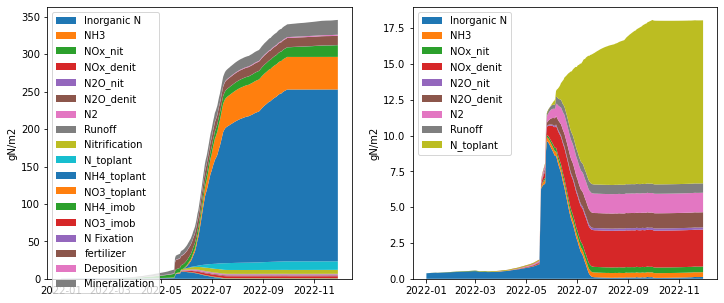

In [37]:
## compile the dataset used for stackplot
plot_time3 = InOrganicN.indexes['time'].to_datetimeindex()

dataset = np.vstack([np.squeeze(InOrganicN.values), np.squeeze(NH3.cumsum().values), np.squeeze(NOxNit.cumsum().values),
                     np.squeeze(NOxDeNit.cumsum().values), np.squeeze(N2ONit.cumsum().values), np.squeeze(N2ODeNit.cumsum().values), 
                     np.squeeze(N2.cumsum().values), np.squeeze(Nrunoff.cumsum().values), np.squeeze(Nnit.cumsum().values), 
                     np.squeeze(NtoPlant.cumsum().values),
                     np.squeeze(NH4toPlant.cumsum().values), np.squeeze(NO3toPlant.cumsum().values), np.squeeze(NH4imob.cumsum().values), 
                     np.squeeze(NO3imon.cumsum().values), np.squeeze(Nfix.cumsum().values), np.squeeze(Nfert.cumsum().values), 
                     np.squeeze(Ndep.cumsum().values), np.squeeze(Nmin.cumsum().values)])

dataset2 = np.vstack([np.squeeze(InOrganicN.values), np.squeeze(NH3.cumsum().values), np.squeeze(NOxNit.cumsum().values),
                     np.squeeze(NOxDeNit.cumsum().values), np.squeeze(N2ONit.cumsum().values), np.squeeze(N2ODeNit.cumsum().values), 
                     np.squeeze(N2.cumsum().values), np.squeeze(Nrunoff.cumsum().values), np.squeeze(NtoPlant.cumsum().values)])

labels = ['Inorganic N', 'NH3', 'NOx_nit', 'NOx_denit', 'N2O_nit', 'N2O_denit', 'N2', 'Runoff', 'Nitrification', 'N_toplant', 'NH4_toplant', 'NO3_toplant', 
          'NH4_imob', 'NO3_imob', 'N Fixation', 'fertilizer', 'Deposition', 'Mineralization']


labels2 = ['Inorganic N', 'NH3', 'NOx_nit', 'NOx_denit', 'N2O_nit', 'N2O_denit', 'N2', 'Runoff','N_toplant']

#Graph
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].stackplot(plot_time3, dataset, labels=labels)
ax[0].set_ylabel("gN/m2")
ax[0].legend(loc='upper left')
ax[1].stackplot(plot_time3, dataset2, labels=labels2)
ax[1].set_ylabel("gN/m2")
ax[1].legend(loc='upper left')
fig.savefig("graphs/N_balance_123kg.jpg", dpi=300)
plt.show()

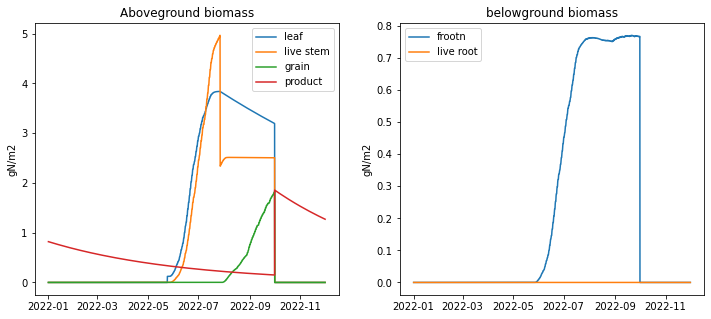

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(plot_time2, dsCLM_Clarion['LEAFN'].values, label='leaf')
ax[0].plot(plot_time2, dsCLM_Clarion['LIVESTEMN'].values, label='live stem')
ax[1].plot(plot_time2, dsCLM_Clarion['FROOTN'].values, label='frootn')
ax[1].plot(plot_time2, dsCLM_Clarion['LIVECROOTN'].values, label='live root')
ax[0].plot(plot_time2, dsCLM_Clarion['GRAINN'].values, label='grain')
ax[0].plot(plot_time2, dsCLM_Clarion['CROPPROD1N'].values, label='product')
ax[0].legend()
ax[0].set_ylabel('gN/m2')
ax[0].set_title('Aboveground biomass')
ax[1].set_ylabel('gN/m2')
ax[1].set_title('belowground biomass')
ax[1].legend()
fig.savefig("graphs/Plant_growth_123kg.jpg", dpi=300)
plt.show()

### 168 kgN fertilizer experiment

### 213 kgN fertilizer experiment